In [1]:
#! /usr/bin/env python

###################################################################################
# Copyright   2015, Pittsburgh Supercomputing Center (PSC).  All Rights Reserved. #
# =============================================================================== #
#                                                                                 #
# Permission to use, copy, and modify this software and its documentation without #
# fee for personal use within your organization is hereby granted, provided that  #
# the above copyright notice is preserved in all copies and that the copyright    #
# and this permission notice appear in supporting documentation.  All other       #
# restrictions and obligations are defined in the GNU Affero General Public       #
# License v3 (AGPL-3.0) located at http://www.gnu.org/licenses/agpl-3.0.html  A   #
# copy of the license is also provided in the top level of the source directory,  #
# in the file LICENSE.txt.                                                        #
#                                                                                 #
###################################################################################

import logging

import os.path
from phacsl.utils.collections.phacollections import SingletonMetaClass
import pyrheautils
from collections import deque, defaultdict
from facilitybase import CareTier
from tools_util import readModelInputs, getFacDict
import yaml

runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_OC.yaml'

inputDict = readModelInputs(runDesc)
facDict = getFacDict(inputDict)

# Drop annoying community entries
dropL = []
for abbrev, rec in facDict.items():
    if rec['category'] == 'COMMUNITY':
        dropL.append(abbrev)
for abbrev in dropL:
    del facDict[abbrev]

print facDict.keys()



['CSNC', 'HOAG', 'LPAL', 'GGMC', 'MANO', 'COVI', 'CVSB', 'SCGL', 'CVLH', 'PACI', 'BGSJ', 'SEAC', 'SJUD', 'ANHC', 'FLAG', 'FVRH', 'KNOT', 'SMMC', 'EVER', 'SJNH', 'HGOR', 'WAMC', 'PALM', 'LAKE', 'COLL', 'GGCH', 'STAN', 'FPCC', 'GORD', 'MSLG', 'CPNH', 'CHAP', 'FOCC', 'KAIA', 'HVAL', 'CARE', 'SCRT', 'SNMR', 'SCNH', 'BEAC', 'VICT', 'PKVW', 'UCIM', 'VIVA', 'LHAB', 'HSOU', 'WAEC', 'TOWN', 'HELP', 'OCGB', 'EXTW', 'ROYL', 'LEIS', 'ACNC', 'ALTA', 'WINA', 'NSUB', 'COCT', 'FREE', 'PREG', 'ELIZ', 'PSUP', 'CVPL', 'TERR', 'PANA', 'MESA', 'LAMC', 'BPNC', 'WINF', 'PVIS', 'GREE', 'HVCC', 'ORRH', 'EDNA', 'ANRG', 'BVCC', 'LPIH', 'NNRC', 'BGYL', 'KINB', 'KINO', 'KINW', 'CAPO', 'ATCC', 'MISS', 'ANGL', 'ALAM', 'OCMM', 'WLNT', 'RGNT', 'QUAK', 'NEWO', 'GPCC', 'SJOS', 'PLAC', 'HBHO']


In [2]:
import phacsl.utils.formats.csv_tools as csv_tools
import phacsl.utils.formats.yaml_tools as yaml_tools
from pyrheautils import pathTranslate

snfDspFname = 'Hospital_and_NH_Disposition_Outcomes_for_RHEA_2.0_-_Adult_Only_-_UPDATED_-_11-15-2017_NH_Outcomes.csv'

snfPath = pathTranslate('$(MODELDIR)/%s' % snfDspFname)
with open(snfPath, 'rU') as f:
    snfKeys, snfRecs = csv_tools.parseCSV(f)
print snfKeys
snfCsvD = {r['NH']: r for r in snfRecs}

[u'NH', u'Total Annual Discharges', u'(1) Patient Died', u'(2) Directly transferred to NH', u'(3) Directly transferred to hospital', u'(4) Discharged to Home**']


In [3]:
hospDspFname = 'Hospital_and_NH_Disposition_Outcomes_for_RHEA_2.0_-_Adult_Only_-_UPDATED_-_11-15-2017_Hosp_Outcomes.csv'

hospPath = pathTranslate('$(MODELDIR)/%s' % hospDspFname)
with open(hospPath, 'rU') as f:
    hospKeys, hospRecs = csv_tools.parseCSV(f)
print hospKeys
hospCsvD = {r['HOSPITAL']: r for r in hospRecs}

[u'HOSPITAL', u'Total Annual Discharges', u'(1) Patient Died', u'(2) Directly transferred to NH', u'(3) Directly transferred to hospital', u'(4) Indirectly transferred to hospital within 365 days', u'(5) Discharged and NOT readmitted to hospital within 365 days']


In [4]:
snfChrFname = 'OC_Hospital_and_Nursing_Home_Characteristics_for_RHEA_2.0_-_Adult_Only_-_09-15-2017_FINAL_NH_CHAR.csv'

with open(pathTranslate('$(MODELDIR)/%s' % snfChrFname), 'rU') as f:
    snfChrKeys, snfChrRecs = csv_tools.parseCSV(f)
print snfChrKeys
snfChrD = {r['RHEA 2.0 CODE']: r for r in snfChrRecs}

[u'CURRENT NAME (2017)', u'RHEA 2.0 CODE', u'"ANNUAL ADMISSIONS ADULT ONLY"', u'TOTAL LICENSED BEDS', u'AVERAGE DAILY CENSUS', u'', u'AVERAGE DAILY CENSUS EXCEEDS TOTAL BEDS']


In [5]:
hospChrFname = 'OC_Hospital_and_Nursing_Home_Characteristics_for_RHEA_2.0_-_Adult_Only_-_09-15-2017_FINAL_HOSP_CHAR.csv'

with open(pathTranslate('$(MODELDIR)/%s' % hospChrFname), 'rU') as f:
    hospChrKeys, hospChrRecs = csv_tools.parseCSV(f)
print hospChrKeys
hospChrD = {r['RHEA 2.0 CODE']: r for r in hospChrRecs}

[u'CURRENT NAME (2017)', u'RHEA 2.0 CODE', u'"ANNUAL ADMISSIONS ADULT ONLY"', u'TOTAL ADULT BEDS', u'TOTAL ADULT ICU BEDS', u'TOTAL ADULT NON-ICU BEDS', u'AVERAGE DAILY CENSUS ADULT ONLY', u'', u'AVERAGE DAILY CENSUS EXCEEDS TOTAL BEDS']


In [82]:
hospLOSFname = 'OC_Hospital_MRSA-Stratified_LOS_Distributions_for_RHEA_2.0_-_Adult_Only_-_09-18-2017_FINAL_MRSAMINUS_LOS_ALL.csv'
with open(pathTranslate('$(MODELDIR)/%s' % hospLOSFname), 'rU') as f:
    hospLOSKeys, hospLOSRecs = csv_tools.parseCSV(f)
print hospLOSKeys
hospLOSD = {r['CODE']: r for r in hospLOSRecs}


[u'CODE', u'N', u'LN_MEAN', u'LN_STD_DEV', u'LN_MEDIAN', u'LN_RANGE', u'LN_IQR']


In [6]:
with open(pathTranslate('$(MODELDIR)/fac_to_cat_marginalized_direct.yaml'), 'rU') as f:
    facToCatD = yaml.load(f)
print facToCatD.keys()

['ACNC', 'ALAM', 'ALTA', 'ANGL', 'ANHC', 'ANRG', 'ATCC', 'BEAC', 'BGSJ', 'BGYL', 'BPNC', 'BVCC', 'CAPO', 'CARE', 'CHAP', 'COCT', 'COLL', 'COVI', 'CPNH', 'CSNC', 'CVLH', 'CVPL', 'CVSB', 'EDNA', 'ELIZ', 'EVER', 'EXTW', 'FLAG', 'FOCC', 'FPCC', 'FREE', 'FVRH', 'GGCH', 'GGMC', 'GORD', 'GPCC', 'GREE', 'HBHO', 'HELP', 'HGOR', 'HOAG', 'HSOU', 'HVAL', 'HVCC', 'KAIA', 'KINB', 'KINO', 'KINW', 'KNOT', 'LAKE', 'LAMC', 'LEIS', 'LHAB', 'LPAL', 'LPIH', 'MANO', 'MESA', 'MISS', 'MSLG', 'NEWO', 'NNRC', 'NSUB', 'OCGB', 'OCMM', 'ORRH', 'PACI', 'PALM', 'PANA', 'PKVW', 'PLAC', 'PREG', 'PSUP', 'PVIS', 'QUAK', 'RGNT', 'ROYL', 'SCGL', 'SCNH', 'SCRT', 'SEAC', 'SJNH', 'SJOS', 'SJUD', 'SMMC', 'SNMR', 'STAN', 'TERR', 'TOWN', 'UCIM', 'VICT', 'VIVA', 'WAEC', 'WAMC', 'WINA', 'WINF', 'WLNT']


In [91]:
with open(pathTranslate('$(MODELDIR)/direct_transfer_counts.yaml'), 'rU') as f:
    directTransferCts = yaml.load(f)
totTransIn = defaultdict(lambda: 0.0)
for src, rec in directTransferCts.items():
    for dst, ct in rec.items():
        totTransIn[dst] += ct
print totTransIn['SJNH']

9.5


In [92]:
from scipy.stats.distributions import rv_continuous, lognorm
import math
newFacDict = {}
directMtxFname = 'OC_Direct_Transfer_Matrices_for_RHEA_2.0_-_Adult_Only_-_09-15-2017_FINAL.xlsx'
for abbrev, rec in facDict.items():
    newR = rec.copy()
    if rec['category'] == 'NURSINGHOME':
        transProv = ('(%s summed by dest category and normalized) * (%s total discharges * frac to NH or HOSP)'
                     % (directMtxFname, snfDspFname))
        meanPopProv = "%s col 'AVERAGE DAILY CENSUS'" % snfChrFname
        nBedsProv = "%s col 'TOTAL LICENSED BEDS'" % snfChrFname
        if abbrev in snfCsvD:
            csvR = snfCsvD[abbrev]
            totDsch = csvR['Total Annual Discharges']
            totTrans = totDsch * (1.0 - (csvR[u'(4) Discharged to Home**'] + csvR[u'(1) Patient Died']))
            
            tNHFrac = facToCatD[abbrev]['NURSINGHOME'] if 'NURSINGHOME' in facToCatD[abbrev] else 0.0
            tLTACFrac = facToCatD[abbrev]['LTAC'] if 'LTAC' in facToCatD[abbrev] else 0.0
            tHospFrac = facToCatD[abbrev]['HOSPITAL'] if 'HOSPITAL' in facToCatD[abbrev] else 0.0
            newR['totalDischarges'] = {'value': totDsch,
                                      'prov': '%s col B' % snfDspFname}
            
            newR['totalTransfersOut'] = [
                {'category': 'NURSINGHOME', 'count': {'value': totTrans*tNHFrac, 'prov': transProv}},
                {'category': 'LTAC', 'count': {'value': totTrans*tLTACFrac, 'prov': transProv}},
                {'category': 'HOSPITAL', 'count': {'value': totTrans*tHospFrac, 'prov': transProv}}
            ]
            newR['meanPop'] = {'value': snfChrD[abbrev]['AVERAGE DAILY CENSUS'],
                              'prov': meanPopProv}
            newR['nBeds'] = {'value': snfChrD[abbrev]['TOTAL LICENSED BEDS'],
                            'prov': nBedsProv}
            newR['meanLOSICU'] = {'value': 0.0, 'prov': 'NURSINGHOMEs do not have ICUs'}
            newR['fracAdultPatientDaysICU'] = {'value': 0.0, 'prov': 'NURSINGHOMEs do not have ICUs'}
            newR['totalTransfersIn'] = {'value': totTransIn[abbrev],
                                       'prov': ('translate_direct_transfer_data_OC.py 7b812e1a'
                                                + ' with input CSVs bdfa32e4')}
        else:
            print 'No data for %s' % abbrev
    elif rec['category'] in ['HOSPITAL', 'LTAC']:
        transProv = ('(%s summed by dest category and normalized) * (%s total discharges * frac to NH or HOSP)'
                     % (directMtxFname, hospDspFname))
        meanPopProv = "%s col 'AVERAGE DAILY CENSUS'" % hospChrFname
        nBedsProv = "%s col 'TOTAL LICENSED BEDS'" % hospChrFname
        if abbrev in hospCsvD:
            csvR = hospCsvD[abbrev]
            totDsch = csvR['Total Annual Discharges']
            totTrans = totDsch * (1.0 - (csvR[u'(4) Indirectly transferred to hospital within 365 days']
                                         + csvR[u'(5) Discharged and NOT readmitted to hospital within 365 days']
                                         + csvR[u'(1) Patient Died']))
            tNHFrac = facToCatD[abbrev]['NURSINGHOME'] if 'NURSINGHOME' in facToCatD[abbrev] else 0.0
            tLTACFrac = facToCatD[abbrev]['LTAC'] if 'LTAC' in facToCatD[abbrev] else 0.0
            tHospFrac = facToCatD[abbrev]['HOSPITAL'] if 'HOSPITAL' in facToCatD[abbrev] else 0.0
            newR['totalDischarges'] = {'value': totDsch,
                                      'prov': '%s col B' % hospDspFname}
            newR['totalTransfersOut'] = [
                {'category': 'NURSINGHOME', 'count': {'value': totTrans*tNHFrac, 'prov': transProv}},
                {'category': 'LTAC', 'count': {'value': totTrans*tLTACFrac, 'prov': transProv}},
                {'category': 'HOSPITAL', 'count': {'value': totTrans*tHospFrac, 'prov': transProv}}
            ]
            newR['meanPop'] = {'value': hospChrD[abbrev][u'AVERAGE DAILY CENSUS ADULT ONLY'],
                            'prov': meanPopProv}
            newR['nBeds'] = {'value':hospChrD[abbrev]['TOTAL ADULT BEDS'],
                            'prov': nBedsProv}
            losMu = hospLOSD[abbrev]['LN_MEAN']
            losSigma = hospLOSD[abbrev]['LN_STD_DEV']
            losRV = lognorm(losSigma, scale=math.exp(losMu), loc=0.0)
            meanLOS = rv.mean()
            newR['meanLOS'] = {'value': float(losRV.mean()), 
                               'prov':'%s mean of lognorm(sigma=LN_STD_DEV, mu=LN_MEAN)'% hospLOSFname}
            newR['losModel'] = {'parms': [losMu, losSigma], 'pdf': 'lognorm(mu=$0,sigma=$1)',
                               'prov': '%s lognorm(sigma=LN_STD_DEV, mu=LN_MEAN)' % hospLOSFname}
            newR['totalTransfersIn'] = {'value': totTransIn[abbrev],
                                       'prov': ('translate_direct_transfer_data_OC.py 7b812e1a'
                                                + ' with input CSVs bdfa32e4')}

    newFacDict[abbrev] = newR
yaml_tools.save_all(pathTranslate('$(MODELDIR)/facilityfactsUpdated'), newFacDict.values())

In [37]:
from scipy.stats.distributions import rv_continuous, lognorm
import math
# 1.94 is the ln of the mean
# .83 is the ln of stdv
mu = 1.94
sigma = 0.83
rv = lognorm(sigma, math.exp(mu))
print rv.mean(), rv.median()


8.36996450937344 7.958750970637272


In [54]:
mean = math.exp(1.94)
stdv = math.exp(0.83)
#mu = math.log(mean) - (0.5*stdv*stdv)
mu = mean - (0.5*stdv*stdv)
#rv = lognorm(stdv, scale=math.exp(mu), loc=0.0)
rv1 = lognorm(0.83, scale=mu, loc=0.0)
print rv1.median()

4.329095548413823


In [79]:
mu = 1.94
#mu = 0.0
sigma = 0.83
#sigma = 1.0
rv2 = lognorm(sigma, scale=math.exp(mu), loc=0.0)
print 'mean:   ', rv2.mean()
print 'median: ', rv2.median()

mean:    9.820283582456778
median:  6.958750970637272


In [76]:
mu = 1.94
#mu = 0.0
sigma = 0.83
#sigma = 1.0
rv3 = lognorm(sigma, scale=math.exp(mu), loc=10.0)
print 'mean:   ', rv3.mean()
print 'median: ', rv3.median()

mean:    19.820283582456778
median:  16.958750970637272


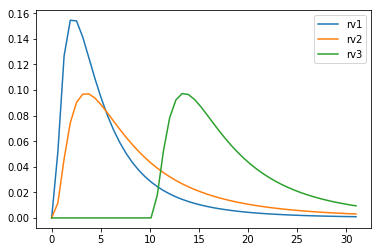

In [77]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
axes = plt.subplot(111)
x = np.linspace(0, 31)
axes.plot(x, rv1.pdf(x), label='rv1')
axes.plot(x, rv2.pdf(x), label='rv2')
axes.plot(x, rv3.pdf(x), label='rv3')
axes.legend()
plt.show()